In [2]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import matplotlib.pyplot as plt
from pylab import savefig
%matplotlib inline

In [3]:
reconstruction = np.load("./1_reconstruction.npy")
features = np.load("./1_features.npy")

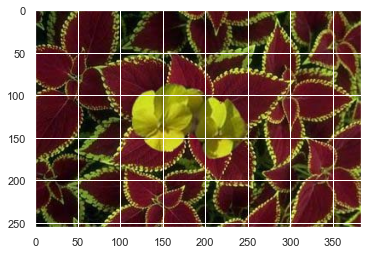

In [4]:
plt.imshow(features)

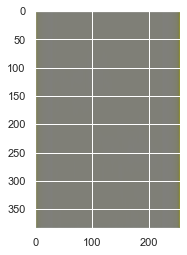

In [98]:
plt.imshow(reconstruction)
plt.imsave("./okokok.jpg", reconstruction, format='png')

<AxesSubplot:>

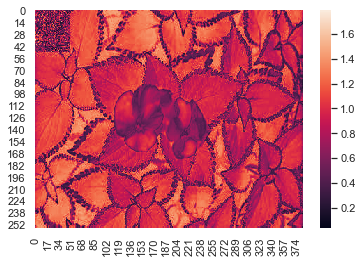

In [97]:
error = np.load("./10_error.npy")
sns.heatmap(error)